In [2]:
import asteroids_async as asteroids

# Async PoC
Let's take existing code generated by GPT4 and turn our control policy function into a coroutine. This is just a manual modification to make sure we understand how async could be used in this context.

In [30]:
import numpy as np

async def control_one_goal(state: asteroids.State) -> asteroids.Action:
  """Control an asteroids-style ship to move to a goal.
  
  Args:
    position: A 2D vector representing the position of the ship.
    goal: A 2D vector representing the position of the goal.
    orientation: A float representing the orientation of the ship in radians.
  Returns:
    A pair of floats representing:
      torque: The amount of torque to apply to the ship, between -1 and 1.
      thrust: The amount of thrust to apply to the ship, between 0.0 and 1
  """
  position = state.position[0]
  goal = state.goal_position[0]
  orientation = state.rotation[0]

  direction_to_goal = np.arctan2(goal[1] - position[1], goal[0] - position[0])
  difference_in_orientation = direction_to_goal - orientation
  
  torque = np.sin(difference_in_orientation)
  distance_to_goal = np.linalg.norm(goal - position)
  thrust = 1.0 if distance_to_goal > 0.1 else 0.0
  
  return asteroids.Action(np.array([torque, thrust])[np.newaxis])

In [31]:
async def policy(state: asteroids.State) -> asteroids.Action:
  action = await control_one_goal(state)
  return action


In [32]:
import matplotlib.pyplot as plt

In [33]:
import asyncio

In [34]:
async def make_plots():
  _, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)

  for ax in [ax1, ax2, ax3, ax4]:
    t = await asteroids.create_trajectory(policy, (1,), steps=300)
    asteroids.plot_trajectory(t, axis=ax)


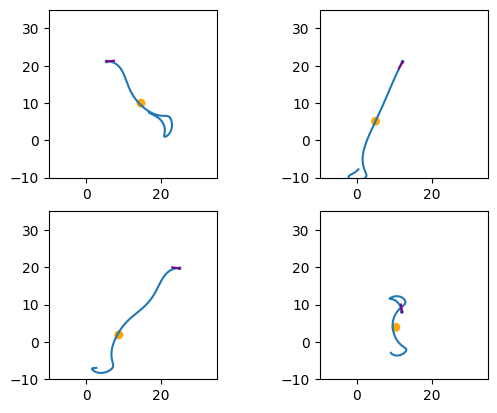

In [35]:
await make_plots()

In [23]:
# Hey LLM, you are now driving the game. You can use the async function control_one_goal,
# which takes a State and produces an Action. Also, you can call dynamics(s, a), which applies
# Action a to State s to return an updated state. Please write a coroutine that runs the game
# until state.has_reached_goal is True. Return the number of steps required to reach the goal.

In [36]:
import dataclasses
import io
import traceback

from matplotlib import pyplot as plt
import numpy as np
import PIL.Image

import sys
sys.path.append('../src/')

import chat
import llm_task

import enact



task_prompt = '''
Write a concise python function with the following signature.
Answer with a single code block.'''
code_gen_prompt = '''

```
async def control_one_goal(state: State) -> action: Action:
  """Control an asteroids-style ship to move to a goal.
  
  Args:
    state: State object encoding the game state. Attributes include
      state.position: Numpy array representing the x and y player position.
      state.goal_position: Numpy array representing the x and y goal position.
      state.rotation: Numpy array representing the player rotation.

      Note that each of these attributes has a batch dimension of 1, so the
      current position of the player can be retrieved via state.position[0].

  Returns:
    An Action object, formed by first producing pair of floats representing:
      torque: The amount of torque to apply to the ship, between -1 and 1.
      thrust: The amount of thrust to apply to the ship, between 0.0 and 1
    The tuple of floats should be returned by wrapping them in 
      Action(np.array([torque, thrust])[np.newaxis])

async def run_game(state: State) -> int:
  """Run the asteroids-style game until the goal is reached.
  
  Args:
    state: State object encoding the initial game state. Relevant attributes include
      state.has_been_at_goal: Numpy array representing whether the player has
        reached the goal.
      state.dynamics: A member function that is called with an Action object to
        produce a new State object.

      Note that the has_been_at_goal attribute has a batch dimension of 1, so the
      current status of the goal can be retrieved via state.has_been_at_goal[0].

  Returns:
    The number of steps taken to reach the goal.
  """
  <INSERT IMPLEMENTATION HERE>
```

To run the game until completion, use the control_one_goal function to produce
an Action for each State, and use the dynamics function to update the State given
the produced Action. Do not define a State class, Action class,
control_one_goal function, or a dynamics function, but instead treat these all 
as already defined.
'''

@enact.typed_invokable(enact.Str, llm_task.ProcessedOutput)
class PolicyChecker(enact.Invokable):

  def call(self, input: enact.Str) -> llm_task.ProcessedOutput:
    if not input.startswith('```python') and not input.startswith('```'):
      return llm_task.ProcessedOutput(
        output=None, correction='Input must start with "```".')
    if not input.endswith('```'):
      return llm_task.ProcessedOutput(
        output=None, correction='Input must end with "```".')
    if '```' in input[3:-3]:
      return llm_task.ProcessedOutput(
        output=None, correction='Input must be a single code block```".')
    if input.startswith('```python'):
      code = input[len('```python`'):-len('```')]
    else:
      code = input[len('```'):-len('```')]
    def_dict = {}
    try:
      exec(code, def_dict)
    except Exception as e:
      return llm_task.ProcessedOutput(
        output=None,
        correction=f'Your code raised an exception while parsing: {e}\n{traceback.format_exc()}')
    control = def_dict.get('run_game')
    if not control:
      return llm_task.ProcessedOutput(
        output=None,
        correction='Your code did not define a `run_game` function.')
    try:
      _ = control(asteroids.State(batch_shape=(1,)))
    except Exception as e:
      return llm_task.ProcessedOutput(
        output=None,
        correction=f'Your code raised an exception while running: {e}\n{traceback.format_exc()}')
    print(code)
    
    return llm_task.ProcessedOutput(
      output=code, correction=None)
      

code_gen = llm_task.Task(
  task_prompt=task_prompt,
  chat_agent=chat.GPTAgent(model='gpt-4'))
code_gen.add_example(
  '''```def add(x: int, y: int):\n  <INSERT IMPLEMENTATION HERE>```''',
  '''```python\ndef add(x: int, y: int):\n  return x + y\n```''')

@enact.typed_invokable(enact.NoneResource, enact.Str)
@dataclasses.dataclass
class CreatePolicy(enact.Invokable):
  code_gen: llm_task.Task
  
  def call(self):
    return self.code_gen(enact.Str(code_gen_prompt))


#store = enact.Store(backend=enact.FileBackend('/home/max/Documents/enact/examples/store_backend/'))
store = enact.Store()
with store:
  post_processor_ref = enact.commit(PolicyChecker())
  code_gen.post_processor = post_processor_ref
  code_gen.max_retries = 10
  create_policy = CreatePolicy(code_gen)


/usr/lib/python3.8/typing.py:500: RuntimeWarning: coroutine 'make_plots' was never awaited
  code = compile(arg, '<string>', 'eval')
/usr/lib/python3.8/typing.py:500: RuntimeWarning: coroutine 'create_trajectory' was never awaited
  code = compile(arg, '<string>', 'eval')


In [37]:
import enact.gradio as gradio

with store:
  ref = enact.commit(create_policy)
  gui = gradio.gradio.GUI(
    ref,
    input_required_outputs=[enact.Image],
    input_required_inputs=[enact.Str])
  gui.launch(share=True)

Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://4ee6bf1b7173a2c652.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


async def run_game(state) -> int:
    steps = 0
    while not state.has_been_at_goal[0]:
        action = await control_one_goal(state)
        state = state.dynamics(action)
        steps += 1
    return steps



/home/max/Documents/enact/src/enact/invocations.py:319: RuntimeWarning: coroutine 'run_game' was never awaited
  return call(arg)


In [38]:
async def run_game(state) -> int:
  steps = 0
  while not state.has_been_at_goal[0]:
    action = await control_one_goal(state)
    state = state.dynamics(action)
    steps += 1
  return steps

In [40]:
await run_game(asteroids.State(batch_shape=(1,)))

116

In [41]:
await run_game(asteroids.State(batch_shape=(1,)))

140

In [42]:
await run_game(asteroids.State(batch_shape=(1,)))

160